# TFQ: Hello, many worlds - Cirq 1.1.0

### by ReDay Zarra

## Setup

In [1]:
import sys
print(sys.version)

3.9.17 (main, Jun  6 2023, 20:11:21) 
[GCC 11.3.0]


In [2]:
import importlib, pkg_resources
importlib.reload(pkg_resources)

<module 'pkg_resources' from '/usr/lib/python3/dist-packages/pkg_resources/__init__.py'>

In [3]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np

2023-07-04 05:38:57.909129: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-07-04 05:38:57.909180: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(
2023-07-04 05:39:24.527267: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-07-04 05:39:24.527942: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-07-04 05:39:24.528007: I tensorflow/stream_executor/cuda/cuda_diagnostics

In [4]:
# Visualization tools: matplotlib and Cirq's svg circuit
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

In [5]:
print("TensorFlow version: ", tf.__version__)
print("TensorFlow Quantum version: ", tfq.__version__)
print("Cirq version: ", cirq.__version__)

TensorFlow version:  2.7.0
TensorFlow Quantum version:  0.7.2
Cirq version:  1.1.0


## 1. Basics

### 1.1 Cirq and parameterized quantum circuits

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


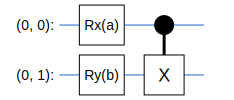

In [6]:
# Cirq uses SymPy symbols to represent free parameters
a, b = sympy.symbols('a b')

# Create two Grid qubits using our parameters
q0, q1 = cirq.GridQubit.rect(1, 2)

# Create a circuit on these qubits using the parameters we created above
circuit = cirq.Circuit(
    cirq.rx(a)(q0),
    cirq.ry(b)(q1), 
    cirq.CNOT(q0, q1))

# Display the circuit using SVGCircuit - you can also print(circuit)
SVGCircuit(circuit)

#### Cirq Simulator

We can evaluate the quantum circuit created in the previous block with specific parameter values for the `a` and `b` parameters. Use the `cirq.Simulator` class which provides methods to **simulate the circuit and obtain the final state** of the quantum system.

In [7]:
# Calculate a state vector with a = 0.5 and b = -0.5.
resolver = cirq.ParamResolver({a: 0.5, b: -0.5})

# Run the simulation with the parameter values on quantum circuit
output_state_vector = cirq.Simulator().simulate(circuit, resolver).final_state_vector
print(output_state_vector)

[ 0.9387913 +0.j         -0.23971277+0.j          0.        +0.06120872j
  0.        -0.23971277j]


After the resolver is created, it is passed to the `simulate` method of a `cirq.Simulator` object along with the circuit to be simulated. The `simulate` method performs the simulation and returns a `SimulationTrialResult` object. The `final_state_vector` attribute of the result is accessed to obtain the final state of the quantum system as a complex numpy array. **Each element of the array corresponds to the amplitude of the respective basis state.**

#### State Vectors

**State Vectors**: a mathematical representation of the state of a quantum system. It's a complex vector that contains amplitude probabilities for each possible state of the system, and its size is 2^n, where n is the number of qubits in the system.

However, when a quantum system is measured, **it collapses to one of its basis states**, and this is the **only information that we can obtain in a real-world**, physical quantum computer. We **cannot directly observe the state vector; it's a theoretical concept** useful for computations and reasoning about quantum systems, but it can't be accessed or measured directly in physical experiments or in quantum hardware.

In [8]:
# Create a Z operator (Pauli Z gate) on the q0 qubit
z0 = cirq.Z(q0)

# Map the qubits to the indices in the state vector
qubit_map={q0: 0, q1: 1}

# Calculate the expectation value of this operator with respect to the provided state vector
z0.expectation_from_state_vector(output_state_vector, qubit_map).real

0.8775825500488281

In quantum computing, we can **calculate the expectation value of an operator, given a particular quantum state**. The expectation value gives us the **average result** if we were to measure the operator on multiple identically prepared quantum states. 

The expectation value of an operator is **calculated by taking the dot product of the state vector with the operator** applied to the state vector.

In [9]:
# Create a new opertor - linear combo of the Z operator on q0 and X operator on q1
z0x1 = 0.5 * z0 + cirq.X(q1)

# Calculate expectation value of new operator with respect to the same state vector
z0x1.expectation_from_state_vector(output_state_vector, qubit_map).real

-0.04063427448272705

### 1.2 Quantum circuits as tensors

TFQ allows you to **integrate quantum circuits into TensorFlow's computation graph**, making it easier to integrate quantum computing with classical machine learning.

In [12]:
# Create a Tensorflow tensor from the list containing one circuit
circuit_tensor = tfq.convert_to_tensor([circuit])

# Access and print the circuit's shape (one-dimensional) and dtype (serialized into a string)
print(circuit_tensor.shape)
print(circuit_tensor.dtype)

(1,)
<dtype: 'string'>


`tfq.convert_to_tensor`: a function that allows you to convert Cirq objects into TensorFlow tensors. 

**Tensors**: the fundamental data structure used in TensorFlow, and they represent a generalization of arrays and matrices to potentially higher dimensions.

In [13]:
# Create a tensor from two Pauli operators 
pauli_tensor = tfq.convert_to_tensor([z0, z0x1])

# The tensor's shape is one-dimensional but contains two elements
pauli_tensor.shape

TensorShape([2])

### 1.3 Batching circuit simulation

**Expectation values**: often used in variational quantum algorithms, which iteratively adjust parameters in a quantum circuit to find the minimum expectation value of a given Hamiltonian.

`tfq.layers.Expectation`: part of TensorFlow Quantum's interface for calculating expectation values. As a `tf.keras.Layer`, it **integrates directly with TensorFlow's model-building** and training infrastructure.

In [14]:
batch_vals = np.array(np.random.uniform(0, 2 * np.pi, (5, 2)), dtype=float)

**Parameterized quantum circuit**: a quantum circuit that has symbolic parameters which can be replaced with specific values.

The `tfq.layers.Expectation` works by **simulating a parameterized quantum circuit with a set of parameter values** provided in the form of a `cirq.ParamResolver` object. However, the `tfq.layers.Expectation` layer is **designed to handle batches of parameters**, adhering to the standard TensorFlow semantics for batched operations. This makes it possible to **pass multiple sets of parameters at once**, and it will compute the expectation values for all of them, typically leading to **more efficient computation**.

In [15]:
cirq_results = []
cirq_simulator = cirq.Simulator()

# Expectation value is being calculated in a loop over different sets of parameter values
for vals in batch_vals:
    resolver = cirq.ParamResolver({a: vals[0], b: vals[1]})
    final_state_vector = cirq_simulator.simulate(circuit, resolver).final_state_vector
    cirq_results.append(
        [z0.expectation_from_state_vector(final_state_vector, {
            q0: 0,
            q1: 1
        }).real])

print('cirq batch results: \n {}'.format(np.array(cirq_results)))

cirq batch results: 
 [[0.83053619]
 [0.47591668]
 [0.12265563]
 [0.07452005]
 [0.05271584]]


The code above uses Cirq to **simulate the results in a final state vector**, which is a complex vector that encodes the quantum state of the system at the end of the circuit execution.

In [16]:
tfq.layers.Expectation()(circuit,
                         symbol_names=[a, b],
                         symbol_values=batch_vals,
                         operators=z0)

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[0.83053595],
       [0.47591832],
       [0.12265509],
       [0.07451963],
       [0.05271763]], dtype=float32)>

TFQ can be used to accomplish the same thing in a more efficient way. The `tfq.layers.Expectation` function **creates a layer that computes the expectation values** of the specified operators when the circuit is executed with the given parameter values.

## 2. Hybrid quantum-classical optimization

The term "hybrid quantum-classical optimization" refers to the fact that the setup involves **optimizing a classical neural network to control a quantum system**.

Hybrid quantum-classical optimization is based on the premise that a **classical neural network is trained to control the state of a single qubit**. The goal is to guide the qubit to reach either the state |0⟩ or the state |1⟩, **overcoming a simulated systematic calibration error.**

#### Hybrid System Architecture

**Input circuit or datapoint circuit**: a quantum circuit consisting of **the first three 𝜋/8 gates**. These gates prepare the initial state of the qubit, which will then be processed by the rest of the system.

**Controlled circuit**: another quantum circuit consisting of **the other three 𝜋/8 gates**. The parameters of these gates, which determine how they transform the qubit's state, are **controlled by the output of the classical neural network**.

**Controller**: a classical neural network that takes some **classical data as input and outputs the parameters** for the controlled circuit. The goal of training this network is to **find parameters** that cause the controlled circuit **to drive the qubit to the correct state** (either |0⟩ or |1⟩) for each input.